In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""

import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc


from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import HTML


import pandas as pd
import time

from functools import partial

import os

#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)   

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# System's parmeters

In [2]:
# In order to change the parameters of the system, such as number of shops, trucks, etc, one must change
# the corresponding constants in the 'constants.py' file from the 'gym pd_system' package.

CASE = ct.CASE
STOCHASTIC = ct.STOCHASTIC 

###########################################################

TANK_MAX_LOADS = ct.TANK_MAX_LOADS
LEVEL_PERCENTAGES = ct.LEVEL_PERCENTAGES 
TRUCK_MAX_LOADS = ct.TRUCK_MAX_LOADS
GRAPH_WEIGHTS = ct.GRAPH_WEIGHTS 
DISCRETE = ct.DISCRETE

n = len(TANK_MAX_LOADS)
k = len(TRUCK_MAX_LOADS)

env = gym.make("PDSystemEnv-v0")
episode_length = 30
env._max_episode_steps = episode_length

###########################################################

print("System with k={} trucks and n={} shops. Episodes of {} days.".format(k,n,episode_length))

System with k=2 trucks and n=5 shops. Episodes of 30 days.


In [3]:
import utils_pg
from utils_pg import int_to_action
from utils_pg import action_to_int
from utils_pg import discount_rewards
from utils_pg import normalize_rewards

# Tensorflow graph (DNN) for MC Policy Gradient Algorithm

In [4]:
simulation_id = 319

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
models_dir = simulation_directory + '/NN-models'

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(models_dir)
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["iteration", "discreward"]], fmt="%s", delimiter=',')

Exception: The simulation id you tried to use has been already used before. Try to change it to a new one.

In [5]:
seed = 42
reset_graph(seed)

################################
# TensorBoard summary directories
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)   
################################

## DNN hyperparameters ################
learning_rate = 0.01 #0.01

hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

# batch_normalization = True  
# batch_norm_momentum = 0.9
######################################



######################################
#### Training hyperparameters ########
######################################
# File names for the model

model_file = models_dir + "/pdenv_policy_net_pg.ckpt"#.format(learning_rate)
best_model_file = models_dir + "/pdenv_best_policy_net_pg.ckpt"#.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)


# Simulation / Training parameters
n_games_per_update = 10
n_max_steps = episode_length
n_iterations = 10**5 #2*10**4
save_iterations = 100 # USEFUL WHEN USING EARLY STOPPING
discount_rate = 0.9

info_freq = 100 #100
round_time = 2
round_reward = 6
summary_freq = 20#int(info_freq/2), 10

# Early stopping
max_checks_without_progress = np.inf # 10,  one for each "info_freq" (in terms of iterations it would be
                                                            #max_checks_without_progress *  info_freq)
checks_without_progress = 0
best_reward = -np.infty


retrain = False
########################################



###### TENSORFLOW GRAPH #########
tf.set_random_seed(seed)
with tf.name_scope("dnn"):
        
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid#tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid#tf.nn.elu
            n_outputs = env.action_space.shape[1]**env.action_space.shape[0]
            
            he_init = tf.contrib.layers.variance_scaling_initializer(seed = seed)

            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            
                    
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = he_init)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = he_init)
            logits = tf.layers.dense(hidden2, n_outputs, name = "logits"
                                     ,kernel_initializer = he_init)
            
            outputs = tf.nn.softmax(logits)
                   
            
with tf.name_scope("action"):
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
            test_action = tf.argmax(outputs, axis = 1)
  
            y = tf.reshape(action, [1])
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)


with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            
            grads_and_vars = optimizer.compute_gradients(xentropy)
            gradients = [grad for grad, variable in grads_and_vars]
            gradient_placeholders = []
            grads_and_vars_feed = []
            for grad, variable in grads_and_vars:
                gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
                gradient_placeholders.append(gradient_placeholder)
                grads_and_vars_feed.append((gradient_placeholder, variable))
            training_op = optimizer.apply_gradients(grads_and_vars_feed)
                        
                                       
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
saver = tf.train.Saver()
        

Instructions for updating:
Use the retry module or similar alternatives.


# PG Training

In [ ]:
# with tf.Session() as sess:
    
#     #train_writer = tf.summary.FileWriter(logdir + '/pgtrain', sess.graph)
#     if retrain:
#         saver.restore(sess, model_file)
        
#     summary2 = tf.Summary()
#     if not retrain:
#         init.run()
#     time_start = time.time()

#     for iteration in range(n_iterations+1):
#         print("\rIteration: {}".format(iteration), end="")
#         all_rewards = []
#         all_gradients = []
#         for game in range(n_games_per_update):
#             current_rewards = []
#             current_gradients = []
#             obs = env.reset()
#             for step in range(n_max_steps):
#                 action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) 
#                 #print(action_val)
#                 vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
#                 #print(vect_action)
#                 obs, reward, done, info = env.step(vect_action)
#                 current_rewards.append(reward)
#                 current_gradients.append(gradients_val)                
                
#                 if done:
#                     break
#             all_rewards.append(current_rewards)
#             all_gradients.append(current_gradients)
            
        
#         all_disc_rewards =  [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
#         all_disc_norm_rewards = normalize_rewards(all_disc_rewards)     

#         feed_dict = {}
#         for var_index, gradient_placeholder in enumerate(gradient_placeholders):
#             mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
#                                       for game_index, rewards in enumerate(all_disc_norm_rewards)
#                                           for step, reward in enumerate(rewards)], axis=0)
#             feed_dict[gradient_placeholder] = mean_gradients
         
       
#         #tf.summary.scalar('avg_rewards', avg_rewards)
#         #train_writer.add_summary(avg_rewards, iteration)

#         # Summary and info printings     ###################################################################
#         if iteration % info_freq == 0 or iteration % summary_freq == 0:  
            
#             #avg_rewards =np.array([np.mean(np.array(all_rewards)) / n_games_per_update])
#             avg_rewards =np.mean(np.array(all_disc_rewards)) / n_games_per_update
# #             print(avg_rewards)
#             #avg_rewards_list.append(avg_rewards)
#             if iteration % summary_freq == 0:
#                 summary2.value.add(tag='average_reward_per_game', simple_value = avg_rewards)
#                 file_writer.add_summary(summary2, iteration)

#                 feed_dict[X] = obs.reshape(1, n_inputs)
#                 summary = sess.run(merged, feed_dict= feed_dict)

#                 file_writer.add_summary(summary, iteration)
                
#                   # Disc rewards, etc ####
       
#                 with open(rewards_file,'ab') as f:
#                             np.savetxt(f, [np.array([iteration,  avg_rewards])], fmt=("%d",'%.10f'), delimiter=',') 

#             if iteration % info_freq == 0:
#                 time_end = time.time()
#                 print(". Average reward per game: ",  round(avg_rewards, round_reward), 
#                       ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
                
                
#         ###########################################################################      
                
#         if avg_rewards > best_reward:
#                     saver.save(sess, best_model_file)
#                     print("Saved Model with average discounted rewards per game ", avg_rewards)
#                     best_reward = avg_rewards
#                     checks_without_progress = 0
#         else:
#                     checks_without_progress += 1
#                     if checks_without_progress > max_checks_without_progress:
#                         print("Early stopping!")
#                         break
#         ####################################################################################################
#         if iteration % save_iterations == 0:
#                  saver.save(sess, model_file)
        
#         sess.run(training_op, feed_dict=feed_dict)
    
#     #saver.save(sess, model_file + "final")
#     file_writer.flush()
#     file_writer.close()
                 
#     time_end = time.time()
#     print("Simulation finished. Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
        

Iteration: 0. Average reward per game:  -1.87581 , Elapsed time  0.01  minutes.
Saved Model with average discounted rewards per game  -1.8758101123618958
Iteration: 20Saved Model with average discounted rewards per game  -1.079953923457361
Iteration: 40Saved Model with average discounted rewards per game  -0.8084117456136838
Iteration: 60Saved Model with average discounted rewards per game  -0.6598071208721041
Iteration: 80Saved Model with average discounted rewards per game  -0.5834398794677037
Iteration: 100. Average reward per game:  -0.511656 , Elapsed time  1.13  minutes.
Saved Model with average discounted rewards per game  -0.5116562324061938
Iteration: 120Saved Model with average discounted rewards per game  -0.33587520181549013
Iteration: 140Saved Model with average discounted rewards per game  -0.30063700138600846
Iteration: 160Saved Model with average discounted rewards per game  -0.23938606352292197
Iteration: 200. Average reward per game:  -0.314953 , Elapsed time  2.18  m

Iteration: 7900. Average reward per game:  -0.208967 , Elapsed time  92.84  minutes.
Iteration: 8000. Average reward per game:  -0.162068 , Elapsed time  93.98  minutes.
Iteration: 8100. Average reward per game:  -0.17617 , Elapsed time  95.12  minutes.
Iteration: 8200. Average reward per game:  -0.157048 , Elapsed time  96.27  minutes.
Iteration: 8300. Average reward per game:  -0.144555 , Elapsed time  97.4  minutes.
Iteration: 8400. Average reward per game:  -0.154324 , Elapsed time  98.53  minutes.
Iteration: 8500. Average reward per game:  -0.144316 , Elapsed time  99.66  minutes.
Iteration: 8600. Average reward per game:  -0.15604 , Elapsed time  100.79  minutes.
Iteration: 8700. Average reward per game:  -0.134325 , Elapsed time  101.91  minutes.
Iteration: 8800. Average reward per game:  -0.138276 , Elapsed time  103.05  minutes.
Iteration: 8900. Average reward per game:  -0.129515 , Elapsed time  104.19  minutes.
Iteration: 9000. Average reward per game:  -0.163547 , Elapsed t

Iteration: 17100. Average reward per game:  -0.13086 , Elapsed time  198.71  minutes.
Iteration: 17200. Average reward per game:  -0.121176 , Elapsed time  199.87  minutes.
Iteration: 17300. Average reward per game:  -0.126565 , Elapsed time  201.04  minutes.
Iteration: 17400. Average reward per game:  -0.132076 , Elapsed time  202.19  minutes.
Iteration: 17500. Average reward per game:  -0.120106 , Elapsed time  203.34  minutes.
Iteration: 17600. Average reward per game:  -0.104664 , Elapsed time  204.49  minutes.
Iteration: 17700. Average reward per game:  -0.106892 , Elapsed time  205.68  minutes.
Iteration: 17800. Average reward per game:  -0.11623 , Elapsed time  206.82  minutes.
Iteration: 17900. Average reward per game:  -0.114471 , Elapsed time  207.96  minutes.
Iteration: 18000. Average reward per game:  -0.105281 , Elapsed time  209.16  minutes.
Iteration: 18100. Average reward per game:  -0.130544 , Elapsed time  210.54  minutes.
Iteration: 18200. Average reward per game:  -

Iteration: 26500. Average reward per game:  -0.139071 , Elapsed time  310.06  minutes.
Iteration: 26600. Average reward per game:  -0.107218 , Elapsed time  311.21  minutes.
Iteration: 26700. Average reward per game:  -0.104784 , Elapsed time  312.35  minutes.
Iteration: 26800. Average reward per game:  -0.0985 , Elapsed time  313.5  minutes.
Iteration: 26900. Average reward per game:  -0.09401 , Elapsed time  314.64  minutes.
Iteration: 27000. Average reward per game:  -0.112992 , Elapsed time  315.79  minutes.
Iteration: 27100. Average reward per game:  -0.111185 , Elapsed time  316.93  minutes.
Iteration: 27200. Average reward per game:  -0.095573 , Elapsed time  318.04  minutes.
Iteration: 27300. Average reward per game:  -0.121602 , Elapsed time  319.16  minutes.
Iteration: 27400. Average reward per game:  -0.135981 , Elapsed time  320.31  minutes.
Iteration: 27500. Average reward per game:  -0.106358 , Elapsed time  321.46  minutes.
Iteration: 27600. Average reward per game:  -0.

Iteration: 36000. Average reward per game:  -0.117925 , Elapsed time  422.72  minutes.
Iteration: 36100. Average reward per game:  -0.125926 , Elapsed time  424.1  minutes.
Iteration: 36200. Average reward per game:  -0.126783 , Elapsed time  425.33  minutes.
Iteration: 36300. Average reward per game:  -0.099675 , Elapsed time  426.58  minutes.
Iteration: 36400. Average reward per game:  -0.118628 , Elapsed time  427.94  minutes.
Iteration: 36500. Average reward per game:  -0.097339 , Elapsed time  429.25  minutes.
Iteration: 36600. Average reward per game:  -0.117404 , Elapsed time  430.63  minutes.
Iteration: 36700. Average reward per game:  -0.091426 , Elapsed time  431.93  minutes.
Iteration: 36800. Average reward per game:  -0.104891 , Elapsed time  433.16  minutes.
Iteration: 36900. Average reward per game:  -0.118462 , Elapsed time  434.38  minutes.
Iteration: 37000. Average reward per game:  -0.123709 , Elapsed time  435.6  minutes.
Iteration: 37100. Average reward per game:  -

Iteration: 45500. Average reward per game:  -0.113546 , Elapsed time  539.17  minutes.
Iteration: 45600. Average reward per game:  -0.13985 , Elapsed time  540.39  minutes.
Iteration: 45700. Average reward per game:  -0.138064 , Elapsed time  541.6  minutes.
Iteration: 45800. Average reward per game:  -0.138828 , Elapsed time  542.83  minutes.
Iteration: 45900. Average reward per game:  -0.124829 , Elapsed time  544.05  minutes.
Iteration: 46000. Average reward per game:  -0.109582 , Elapsed time  545.29  minutes.
Iteration: 46100. Average reward per game:  -0.123256 , Elapsed time  546.52  minutes.
Iteration: 46200. Average reward per game:  -0.140905 , Elapsed time  547.75  minutes.
Iteration: 46300. Average reward per game:  -0.139298 , Elapsed time  548.97  minutes.
Iteration: 46400. Average reward per game:  -0.121819 , Elapsed time  550.2  minutes.
Iteration: 46500. Average reward per game:  -0.142537 , Elapsed time  551.52  minutes.
Iteration: 46600. Average reward per game:  -0

Iteration: 55000. Average reward per game:  -0.101074 , Elapsed time  658.03  minutes.
Iteration: 55100. Average reward per game:  -0.109857 , Elapsed time  659.28  minutes.
Iteration: 55200. Average reward per game:  -0.099799 , Elapsed time  660.54  minutes.
Iteration: 55300. Average reward per game:  -0.133508 , Elapsed time  661.78  minutes.
Iteration: 55400. Average reward per game:  -0.115103 , Elapsed time  663.03  minutes.
Iteration: 55500. Average reward per game:  -0.117648 , Elapsed time  664.3  minutes.
Iteration: 55600. Average reward per game:  -0.109736 , Elapsed time  665.54  minutes.
Iteration: 55700. Average reward per game:  -0.100466 , Elapsed time  666.81  minutes.
Iteration: 55800. Average reward per game:  -0.134505 , Elapsed time  668.06  minutes.
Iteration: 55900. Average reward per game:  -0.130645 , Elapsed time  669.29  minutes.
Iteration: 56000. Average reward per game:  -0.148442 , Elapsed time  670.52  minutes.
Iteration: 56100. Average reward per game:  

Iteration: 64200. Average reward per game:  -0.092971 , Elapsed time  770.36  minutes.
Iteration: 64300. Average reward per game:  -0.117307 , Elapsed time  771.6  minutes.
Iteration: 64400. Average reward per game:  -0.096303 , Elapsed time  772.82  minutes.
Iteration: 64500. Average reward per game:  -0.087847 , Elapsed time  774.04  minutes.
Iteration: 64600. Average reward per game:  -0.102979 , Elapsed time  775.24  minutes.
Iteration: 64700. Average reward per game:  -0.10448 , Elapsed time  776.46  minutes.
Iteration: 64800. Average reward per game:  -0.093062 , Elapsed time  777.69  minutes.
Iteration: 64900. Average reward per game:  -0.085699 , Elapsed time  778.95  minutes.
Iteration: 65000. Average reward per game:  -0.082998 , Elapsed time  780.19  minutes.
Iteration: 65100. Average reward per game:  -0.090035 , Elapsed time  781.44  minutes.
Iteration: 65200. Average reward per game:  -0.100008 , Elapsed time  782.68  minutes.
Iteration: 65300. Average reward per game:  -

Iteration: 73600. Average reward per game:  -0.085069 , Elapsed time  888.46  minutes.
Iteration: 73700. Average reward per game:  -0.090577 , Elapsed time  889.69  minutes.
Iteration: 73800. Average reward per game:  -0.084884 , Elapsed time  890.92  minutes.
Iteration: 73900. Average reward per game:  -0.079267 , Elapsed time  892.15  minutes.
Iteration: 74000. Average reward per game:  -0.100876 , Elapsed time  893.32  minutes.
Iteration: 74100. Average reward per game:  -0.108114 , Elapsed time  894.54  minutes.
Iteration: 74200. Average reward per game:  -0.107675 , Elapsed time  895.76  minutes.
Iteration: 74300. Average reward per game:  -0.086915 , Elapsed time  897.0  minutes.
Iteration: 74400. Average reward per game:  -0.100328 , Elapsed time  898.24  minutes.
Iteration: 74500. Average reward per game:  -0.086963 , Elapsed time  899.49  minutes.
Iteration: 74540Saved Model with average discounted rewards per game  -0.07559679088050972
Iteration: 74600. Average reward per gam

## Visualizations

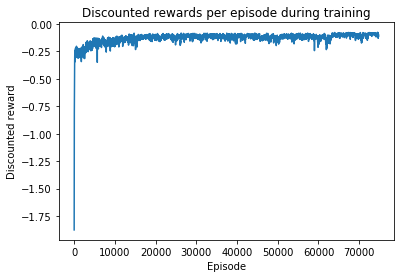

In [6]:
# Visualizing train simulation:

#episode =episodes
#simulation_id = 2
#step = 30

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,n_iterations,1)]

plt.plot(discrewards['iteration'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()

# PG Testing

In [7]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 1

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 


with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
               
        env.close()
    

INFO:tensorflow:Restoring parameters from ./simulations/simulation319/NN-models/pdenv_best_policy_net_pg.ckpt


## Giff animation

In [8]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

## Visualization with matplotlib

In [9]:
from utils_pg import is_empty
from utils_pg import my_indicator

def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    #tanks = test_toy_system.tanks
    tanks_max_load = system.tank_max_loads
    level_percentages = system.load_level_percentages

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
            plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = level_percentages[i-1]           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length*n_episodes+1,5*n_episodes
                        ))
        
        #################### INFO LEVELS
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks_max_load[i-1]
        x_maxs = np.array([b,c,e,1])*tanks_max_load[i-1]

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)
        ###################################################

    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()

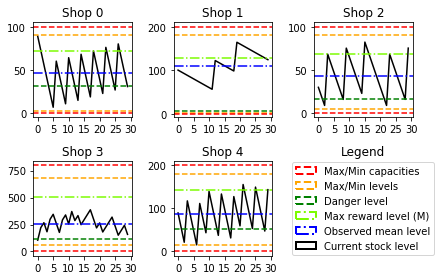

In [10]:
test_level_counts_list = []

visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list = test_level_counts_list)   

## Performance metrics

INFO:tensorflow:Restoring parameters from ./simulations/simulation319/NN-models/pdenv_best_policy_net_pg.ckpt


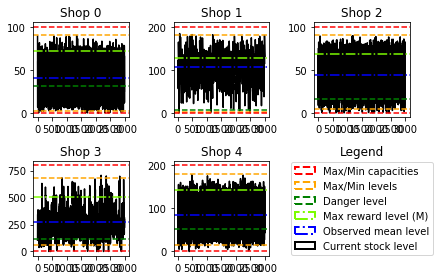

Total discounted rewards Level rewards Transport rewards
-224097.69661639901 -361205.4264422826 31815.689903699993
Average trucks sent:  40.68
Average 1st type Trucks sent to each shop: [ 6.82  1.81  4.45  3.09  0.   13.83]
Average 1st type Trucks sent: 16.17
Average 2nd type Trucks sent to each shop: [ 0.    0.    0.   16.72  7.79  5.49]
Average 2nd type Trucks sent: 24.509999999999998
Average number of trucks not deliverying: 0.09
Average level counts for shop 0: [ 0.07  0.06 10.65 19.22  0.  ]
Average level counts for shop 1: [4.000e-02 2.000e-02 4.000e-02 2.986e+01 4.000e-02]
Average level counts for shop 2: [ 0.09  0.37  2.73 26.81  0.  ]
Average level counts for shop 3: [ 0.06  0.48  1.44 27.97  0.05]
Average level counts for shop 4: [1.000e-02 5.600e-01 6.840e+00 2.259e+01 0.000e+00]
Average total level counts: [2.7000e-01 1.4900e+00 2.1700e+01 1.2645e+02 9.0000e-02]
Percentage total level counts: [1.80000000e-01 9.93333333e-01 1.44666667e+01 8.43000000e+01
 6.00000000e-02]


In [12]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 100

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

####
test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []
####

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            #####
            discounted_reward = 0 
            transport_rewards = 0
            level_rewards = 0
            number_of_trucks_sent = 0
            number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_trucks_not_deliverying = 0                   
            #####         
         
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
            
                trucks_not_del = info["trucks_not_deliverying"]
                level_reward = info["level_rewards"]
                transport_reward = info["transport_rewards"]
                ### STORE STEP INFO
                discounted_reward = discounted_reward + (discount_rate**(step)) * reward
                transport_rewards = transport_rewards+transport_reward
                level_rewards = level_rewards + level_reward
                
                number_of_trucks_sent = number_of_trucks_sent + np.sum(vect_action == 5)
                index1 = vect_action[0]
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = vect_action[1]
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
            test_rewards_list.append(discounted_reward);
            test_transport_rewards_list.append(transport_rewards);
            test_level_rewards_list.append(level_rewards);
            test_trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            test_number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            test_number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            test_number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);                   
                
               
        env.close()
        
test_level_counts_list = []

visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list = test_level_counts_list) 

print("Total discounted rewards","Level rewards", "Transport rewards")
print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
#     if n_episodes == 1:
first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
print("Average 1st type Trucks sent to each shop:", first_type)
print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
print("Average 2nd type Trucks sent to each shop:", second_type)
print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

for i in range(n):
        print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )

        
print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )